# Chapter 2

In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch as T
import sympy as sp

from scm import SymbolicSCM

print(sys.version)

3.11.2 (main, Mar 27 2023, 18:39:42) [Clang 14.0.6 ]



# Definition 2.1.1 -- Structural Causal Model (SCM).

A structural causal model $\mathcal M$ is a 4-tuple $\langle \mathbf U, \mathbf V, \mathcal F, P(\mathbf U)$, where

- $\mathbf U$ is a set of background variables, also called exogenous variables, that are determined by factors outside the model;
- $\mathbf V$ is a set $\{V_1, \dots V_n\}$ of variables, called endogenous, that are determined by other variables in the model — that is, variables in $\mathbf U \cup \mathbf V$.
- $\mathcal F$ is a set of functions $\{f_1, \dots f_n\}$ such that each $f_i$ is a mapping from (the respective domains of) $U_i \cup \mathbf{Pa}_i$ to $V_i$, where $U_i \in \mathbf U, \mathbf{Pa}_i \in \mathbf V \setminus V_i$, and the entire set $\mathcal F$ forms a mapping from $\mathbf U$ to $\mathbf V$. That is, for $i = 1, \dots, n$, each $f_i \in \mathcal F$ is such that

$$v_i \gets f_i(\mathbf{pa}_i, \mathbf{u}_i)$$

i.e., it assigns to a value to $V_i$ that depends on (the values of) a select set of variables in $\mathbf U \cup \mathbf V$; and

- $P(\mathbf U)$ is a probability function defined over the domain of $\mathbf U$.

## Example 2.1
Consider a game of chance described through the SCM $\mathcal M^1 = \langle \mathbf U = \{U_1, U_2\}, \mathbf V = \{X, Y\}, \mathcal F, P(U_1, U_2)\rangle$, where

$$\mathcal F = \begin{cases}
X &\gets U_1 + U_2 \\
Y &\gets U_1 - U_2
\end{cases}$$

and $P(U_i = k) = 1/6$; $i = 1,2$; $k = 1, \dots, 6$.

In [2]:
x, y, u1, u2 = sp.symbols('x y u1 u2')

m1 = SymbolicSCM(
    f={
        x: u1 + u2,
        y: u1 - u2,
    },
    pu={
        u1: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
        u2: [0, 1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
    }
)

In [3]:
m1.get_probability_table(u=True).head()

,u1,u2,x,y,probability
0,1,1,2,0,0.027778
1,1,2,3,-1,0.027778
2,1,3,4,-2,0.027778
3,1,4,5,-3,0.027778
4,1,5,6,-4,0.027778


In [4]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


First, we plot an empirical histogram of each variable's using $10^6$ samples drawn from its distribution.

In [5]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# sns.histplot(v['x'], label='x', ax=axes[0], discrete=True, stat="probability")
# axes[0].set_title('x')   
# sns.histplot(v['y'], label='y', ax=axes[1], discrete=True, stat="probability")
# axes[1].set_title('y')   
# TODO

Then, we compute the joint distribution of $X, Y$. We are able to do so in closed form, given that all variables are discrete.

In [6]:
m1.get_probability_table().head()

,x,y,probability
0,2,0,0.027778
1,3,-1,0.027778
2,3,1,0.027778
3,4,-2,0.027778
4,4,0,0.027778


Text(0.5, 1.0, 'Joint distribution of x and y')

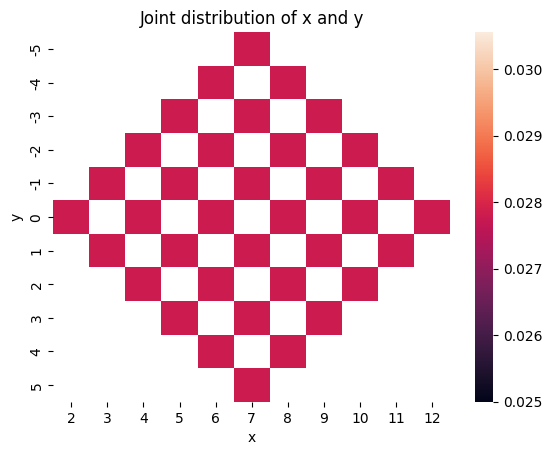

In [7]:
sns.heatmap(pd.pivot(m1.get_probability_table(), index=y, columns=x, values='probability'))
plt.title('Joint distribution of x and y')

# Example 2.2

Consider the following SCM, where the observed variables represent a specific treatment $X$ (e.g., taking a drug), an outcome $Y$ (e.g., survival), and the presence or absence of a symptom $Z$ (e.g., hypertension). The exogenous variables consist of natural resistance to the disease $U_r$ and other unknown sources of variation $U_x, U_y, U_z$.

$$
\mathcal M^2 = \begin{cases}
    \mathbf V &= \{X, Y, Z\}\\
    \mathbf U &= \{U_r, U_x, U_y, U_z\}\\
    \mathcal F &= \begin{cases}
        Z := \mathbf 1[U_r = 1, U_z = 1]\\
        X := \mathbf 1[Z = 1, U_x = 1] + \mathbf 1[Z = 0, U_x = 0]\\
        Y := \mathbf 1[X = 1, U_r = 1] + \mathbf 1[X = 0, U_r = 1, U_y = 1] + \mathbf 1[X = 0, U_r = 0, U_y = 0]\\
    \end{cases}\\
    P(\mathbf U) &= \begin{cases}
       U_r &\sim \mathrm{Bern}(0.25) \\
       U_z &\sim \mathrm{Bern}(0.95) \\
       U_x &\sim \mathrm{Bern}(0.9) \\
       U_y &\sim \mathrm{Bern}(0.7) \\
    \end{cases}
\end{cases}
$$

We may implement this SCM as follows:

In [8]:
z, x, y, ur, uz, ux, uy = sp.symbols('z x y ur uz ux uy')

m2 = SymbolicSCM(
    f={
        z: ur & uz,
        x: z & ux | ~z & ~ux,
        y: x & ur | ~x & ur & uy | ~x & ~ur & ~uy,
    },
    pu={
        ur: 0.25,
        uz: 0.95,
        ux: 0.9,
        uy: 0.7,
    }
)

In [9]:
m2.get_probability_table()

,z,x,y,probability
0,0,0,0,0.475875
1,0,0,1,0.210375
2,0,1,0,0.075000
3,0,1,1,0.001250
4,1,0,0,0.007125
5,1,0,1,0.016625
6,1,1,1,0.213750


## Example 2.3    

We can reproduce Table 2.2 in the textbook as:

In [10]:
m2.get_probability_table(u=True)

,ur,uz,ux,uy,z,x,y,probability
0,0,0,0,0,0,1,0,0.001125
1,0,0,0,1,0,1,0,0.002625
2,0,0,1,0,0,0,1,0.010125
3,0,0,1,1,0,0,0,0.023625
4,0,1,0,0,0,1,0,0.021375
5,0,1,0,1,0,1,0,0.049875
6,0,1,1,0,0,0,1,0.192375
7,0,1,1,1,0,0,0,0.448875
8,1,0,0,0,0,1,1,0.000375
9,1,0,0,1,0,1,1,0.000875


We may evaluate $P(Y = 1 | X = 1)$ as $P(Y = 1, X = 1) / P(X = 1)$ using Bayes' rule:

In [11]:
pt = m2.get_probability_table()
pt.query('x == 1 and y == 1').probability.sum() / pt.query('x == 1').probability.sum()

0.7413793103448276

We implement a convenience function to generate queries, `SCM.query`.

In [12]:
m2.query({y: 1}, given={x: 1})

0.7413793103448276

In [13]:
m2.query({y: 1}, given={x: 0})

0.319718309859155

In [14]:
m2.query({z: 1})

0.23749999999999996

## Example 2.4

In [20]:
m1.query({y: 0})

0.16666666666666669

In [19]:
m1.do({x: 2}).query({y: 0})

0.16666666666666669

## Example 2.5

In [21]:
m2.do({x: 1}).query({y: 1})

0.24999999999999997

In [24]:
m2.query({y: 1}, given={x: 1}) - m2.query({y: 1}, given={x: 0})

0.4216610004856726

In [23]:
m2.do({x: 1}).query({y: 1}) - m2.do({x: 0}).query({y: 1})

-0.15000000000000005